# Segmenting and Clustering Neighborhoods in Toronto

Here starts the "Segmenting and Clustering Neighborhoods in Toronto" Project

## Exploration

### 1.Scraping data from WikiPedia

Importing requested modules

In [1]:
import requests
import pandas as pd
import numpy as np

Reading the table from wikipedia page

In [2]:
# Webpage url                                                                                                               
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# Extract tables
dfs = pd.read_html(url)

# Get first table                                                                                                           
df_raw = dfs[0]

Removing "Not assigned" rows

In [3]:
# Remove Not Assigned
df = df_raw[df_raw['Borough'] != 'Not assigned'].reset_index(drop=True)

Let's have a look at the table

In [4]:
df.shape

(103, 3)

In [5]:
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
df.describe()

,Postal Code,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M6C,North York,Downsview
freq,1,24,4


### 2.Adding latitude and longitude
Import the lat and long csv file (Geocoder not working properly)

In [7]:
pc_coordinates=pd.read_csv('http://cocl.us/Geospatial_data')
pc_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now we join the two tables using 'Postal Code' as a key for joining

In [8]:
df_full=df.set_index('Postal Code').join(pc_coordinates.set_index('Postal Code'))

In [9]:
df_full.reset_index(inplace=True)
df_full.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [10]:
df_full.shape

(103, 5)

### 3.Exploring Neighborhood in the map

#### Creating the map

Importing requested module (for maps and for plots)

In [11]:
#MAPS LIBRARIES
import folium # map rendering library

#PLOTS LIBRARIES
# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

Get only Borough containing 'Toronto'

In [90]:
df_toronto = df_full[df_full['Borough'].str.contains(r'Toronto')].reset_index(drop=True)
df_toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


Creating a map of Toronto with Neighborhoods

In [13]:
# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_full['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [151]:
# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_full['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=True).add_to(map_toronto)  
    
map_toronto

#### Initialize foursquare credentials

In [14]:
CLIENT_ID = 'HDZNPM0PGJAW51WPPBQU521JFFGWY05PLE145J5BIEEQRCU2' # your Foursquare ID
CLIENT_SECRET = 'CKZG5MJELFPC5MPLCTRCYSH141XAEQJXCB024MWYES2CLKEA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HDZNPM0PGJAW51WPPBQU521JFFGWY05PLE145J5BIEEQRCU2
CLIENT_SECRET:CKZG5MJELFPC5MPLCTRCYSH141XAEQJXCB024MWYES2CLKEA


#### Let's create a function to get the venues given lat and long

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the function above on each Neighborhood to get the venues

In [16]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [17]:
print(toronto_venues.shape)
toronto_venues.head(3)

(1618, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


### 4.Exploring venues

Let's check the number of venues per Neighborhood and create e bar plot for better visualization

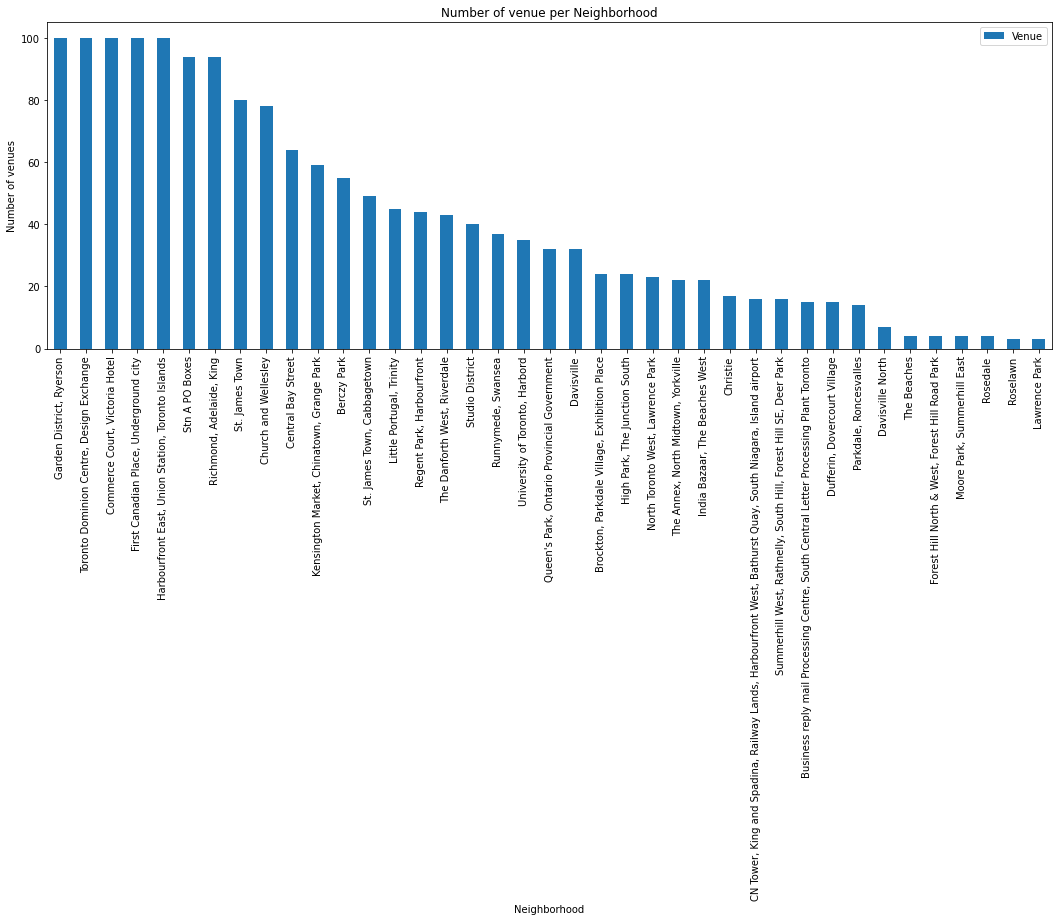

In [18]:
toronto_venues_count = toronto_venues.groupby('Neighborhood').count()[['Venue']].sort_values(by='Venue',ascending=False)
toronto_venues_count.plot(kind='bar', figsize=(18, 6))
plt.ylabel('Number of venues')
plt.title('Number of venue per Neighborhood')
plt.show()

Check unique venues categories

In [19]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 242 uniques categories.


Again another plot would help 

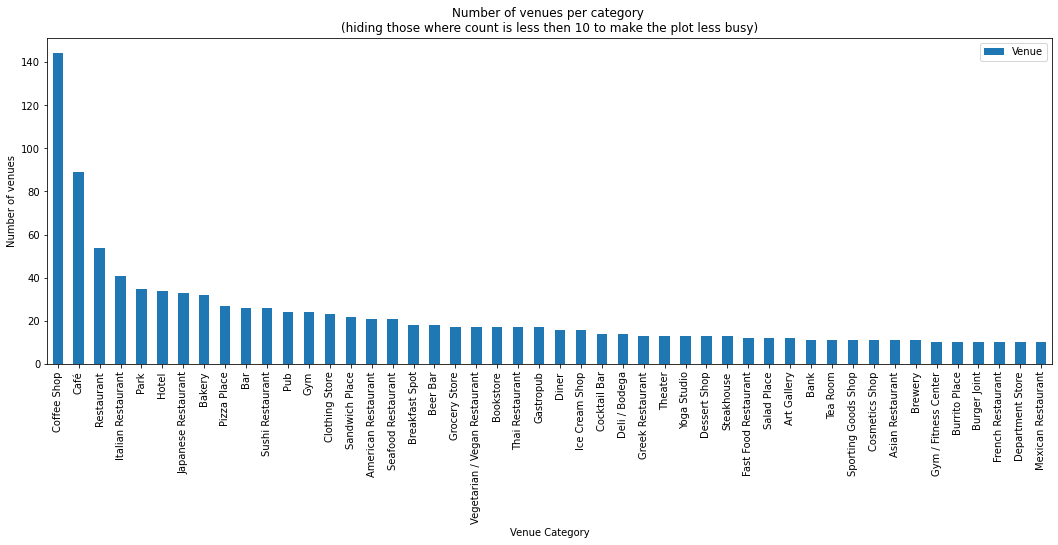

In [20]:
toronto_venues_count = toronto_venues.groupby('Venue Category').count()[['Venue']].sort_values(by='Venue',ascending=False)
toronto_venues_count[toronto_venues_count.Venue>=10].plot(kind='bar', figsize=(18, 6))
plt.ylabel('Number of venues')
plt.title('Number of venues per category \n(hiding those where count is less then 10 to make the plot less busy)')
plt.show()

In [21]:
toronto_venues_count.reset_index(inplace=True)
toronto_venues_count_top5=toronto_venues_count[:5]

Print TOP 5 categories

In [22]:
print('Top 5 categories are:')
for cat in toronto_venues_count_top5['Venue Category']:
    print('\t{}'.format(cat))
    

Top 5 categories are:
	Coffee Shop
	Café
	Restaurant
	Italian Restaurant
	Park


## Analysis

### 1.Analyze Each Neighborhood

In [127]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# not sure why, but if I don't drop the Neighborhood column it does not work
toronto_onehot.drop(['Neighborhood'], axis=1,inplace=True)

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'].values

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
toronto_onehot.shape

(1618, 242)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [129]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.015625,0.000000,0.000000,0.015625,0.000000,0.000000,0.000000,0.015625
5,Christie,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.012821,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.012821,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.012821,0.012821,0.000000,0.025641
7,"Commerce Court, Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.040000,0.000000,...,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000
8,Davisville,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [130]:
#confirm the size
toronto_grouped.shape

(39, 242)

#### Let's print each neighborhood along with the top 5 most common venues

In [131]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
          venue  freq
0   Coffee Shop  0.07
1  Cocktail Bar  0.05
2      Beer Bar  0.04
3          Café  0.04
4    Restaurant  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.12
1  Breakfast Spot  0.08
2     Coffee Shop  0.08
3       Nightclub  0.08
4          Bakery  0.08


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                venue  freq
0  Light Rail Station  0.13
1          Restaurant  0.07
2      Farmers Market  0.07
3             Brewery  0.07
4       Auto Workshop  0.07


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2  Airport Terminal  0.12
3   Harbor / Marina  0.06
4           Airport  0.06


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.17
1   Italian Restaurant  0.

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [132]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [133]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Bakery,Seafood Restaurant,Café,Restaurant,Clothing Store,Diner
1,"Brockton, Parkdale Village, Exhibition Place",Café,Nightclub,Breakfast Spot,Coffee Shop,Bakery,Performing Arts Venue,Pet Store,Convenience Store,Burrito Place,Stadium
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Park,Garden Center,Farmers Market,Fast Food Restaurant,Skate Park,Burrito Place,Butcher,Brewery,Auto Workshop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Bar,Coffee Shop,Rental Car Location,Sculpture Garden,Boat or Ferry,Plane
4,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Japanese Restaurant,Bubble Tea Shop,Department Store,Salad Place,Burger Joint,Ramen Restaurant


### 2.Clustering Neighborhood

In [134]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

Run *k*-means to cluster the neighborhood into 5 clusters.

In [135]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each

In [136]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Bakery,Seafood Restaurant,Café,Restaurant,Clothing Store,Diner
1,"Brockton, Parkdale Village, Exhibition Place",Café,Nightclub,Breakfast Spot,Coffee Shop,Bakery,Performing Arts Venue,Pet Store,Convenience Store,Burrito Place,Stadium
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Park,Garden Center,Farmers Market,Fast Food Restaurant,Skate Park,Burrito Place,Butcher,Brewery,Auto Workshop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Bar,Coffee Shop,Rental Car Location,Sculpture Garden,Boat or Ferry,Plane
4,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Japanese Restaurant,Bubble Tea Shop,Department Store,Salad Place,Burger Joint,Ramen Restaurant


In [137]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto.drop(['Postal Code'],axis=1)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Café,Theater,Beer Store,Ice Cream Shop,Chocolate Shop
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Sushi Restaurant,Yoga Studio,Discount Store,Mexican Restaurant,Diner,Bar,Bank,Beer Bar,Distribution Center
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Clothing Store,Coffee Shop,Italian Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Cosmetics Shop,Bubble Tea Shop,Café,Hotel,Tea Room
3,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cocktail Bar,Gastropub,American Restaurant,Restaurant,Clothing Store,Gym,Creperie,Moroccan Restaurant
4,East Toronto,The Beaches,43.676357,-79.293031,2,Pub,Trail,Health Food Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio


Finally, let's visualize the resulting clusters

In [138]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3.Examin Clusters

Examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, let's assign a name to each cluster.

### Cluster 1

In [139]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
29,"Moore Park, Summerhill East",Lawyer,Park,Tennis Court,Summer Camp,Yoga Studio,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run
33,Rosedale,Park,Playground,Trail,Yoga Studio,Doner Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run


Based on categories, let's call this cluster... "GreenLife"

### Cluster 2

In [140]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Roselawn,Music Venue,Garden,Ice Cream Shop,Dog Run,Dessert Shop,Diner,Discount Store,Distribution Center,Yoga Studio,Department Store


Based on categories, let's call this cluster... "NothingSpecial"

### Cluster 3

In [141]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Café,Theater,Beer Store,Ice Cream Shop,Chocolate Shop
1,"Queen's Park, Ontario Provincial Government",Coffee Shop,Sushi Restaurant,Yoga Studio,Discount Store,Mexican Restaurant,Diner,Bar,Bank,Beer Bar,Distribution Center
2,"Garden District, Ryerson",Clothing Store,Coffee Shop,Italian Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Cosmetics Shop,Bubble Tea Shop,Café,Hotel,Tea Room
3,St. James Town,Coffee Shop,Café,Cocktail Bar,Gastropub,American Restaurant,Restaurant,Clothing Store,Gym,Creperie,Moroccan Restaurant
4,The Beaches,Pub,Trail,Health Food Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
5,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Bakery,Seafood Restaurant,Café,Restaurant,Clothing Store,Diner
6,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Japanese Restaurant,Bubble Tea Shop,Department Store,Salad Place,Burger Joint,Ramen Restaurant
7,Christie,Grocery Store,Café,Park,Restaurant,Baby Store,Italian Restaurant,Diner,Athletics & Sports,Nightclub,Coffee Shop
8,"Richmond, Adelaide, King",Coffee Shop,Café,Restaurant,Thai Restaurant,Hotel,Clothing Store,Deli / Bodega,Gym,Cosmetics Shop,Steakhouse
9,"Dufferin, Dovercourt Village",Bakery,Pharmacy,Grocery Store,Pet Store,Music Venue,Middle Eastern Restaurant,Café,Bus Stop,Brewery,Supermarket


Based on categories, let's call this cluster... "AperitivoTime"